In [29]:
# enable reloading of modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import csv
import numpy as np
from sklearn.metrics import roc_auc_score
from scipy.integrate import simpson

from embeddings_utils.utils import load_with_conditions
from embeddings_utils.classification_utils import brierDecomp, arc_points, compute_winklers_score
from generate_train_test_split import load_open_llm_v2

from typing import List, Tuple, Callable

In [31]:
short_labels_predictive_method = {
    'logistic_regression_l2': 'Logistic Regression (l2)',
    'logistic_regression_l1_c=1': 'Logistic Regression (l1)',
    'logistic_regression_l1_c=0.1': 'Logistic Regression (l1, c=0.1)',
    'xgboost': 'XGBoost',
}

short_labels_features = {
    'openai': 'OpenAI',
    'word2vec': 'Word2Vec',
    'fasttext': 'FastText',
    'ngrams_1': 'Ngrams-1',
    'fineTunedLlama': 'FT-Llama'
}

# Run configuration

In [32]:
in_distribution = True
if in_distribution:
    test_dataset_name = "mmlu_pro"
    filename = os.path.join("results", "mmlu_pro_assessor_results.pkl")
    csv_extension = "_mmlu_pro.csv"
    saved_figure_extension = "_ID"
else:
    test_dataset_name = "bbh"
    filename = os.path.join("results", "bbh_assessor_results_full.pkl")
    csv_extension = "_bbh.csv"
    saved_figure_extension = "_OOD"

# Learn assessors for all LLMs in the MMLU Pro dataset
mmlu_pro_results_file_location = os.path.join("data", "open-llm-leaderboard-v2", "mmlu_pro_results.csv")
# Some model are duplicated, so use set() to dedupe
llms = list(set(pd.read_csv(mmlu_pro_results_file_location)["model"]))
train_dataset_name = "mmlu_pro"
PVR_thresholds = [0.8, 0.9, 0.95]

## Load results


In [33]:
# Load train/test/val split data
train_df, validation_df, test_df = load_open_llm_v2(llms, train_dataset_name, test_dataset_name, exclude_embeddings=True)

In [34]:
# Load results generated by train_embeddings_assessors.ipynb
assessors_results_df = load_with_conditions(filename)
# Remove l1_c=0.1 assessors, as the regularization seems to be too much (they normally become a constant assessor)
assessors_results_df = assessors_results_df[assessors_results_df["predictive_method"] != "logistic_regression_l1_c=0.1"]
print(f"Loaded number considered LLMs: {len(set(assessors_results_df['llm']))}")
print(f"Loaded number of LLM-assessor pairs: {len(assessors_results_df)}")

Loading existing dataframe.
Loaded number considered LLMs: 41
Loaded number of LLM-assessor pairs: 492


In [35]:
# Load results of using a fine tuned Llama 1B to predict
# Excluded for now as Since we're trying to provide a benchmark, and LLama was getting Winkler's scores around -2.2 (while the others were getting ~+/- 0.3)
# LLAMA_PREDICTIVE_METHOD = "FT-Llama"

# llama_assessor_results_loc = os.path.join("..", "..", "results")
# files = [item for item in os.listdir(llama_assessor_results_loc) if csv_extension in item]
# for file in files:
#     # Add a row to the results df for the assessed LLM
#     llm_assessed = file[:-35]
#     if "assessor_Llama-3.2-3B" in file:
#         method = LLAMA_PREDICTIVE_METHOD + "_3.2_3B"
#     elif "assessor_Llama-3.2-1B" in file:
#         method = LLAMA_PREDICTIVE_METHOD + "_3.2_1B"
#     elif "assessor_Llama-3.1-8B" in file:
#         continue # skip to next
#     else:
#         raise ValueError("Unknown Assessor LLM")
#     with open(os.path.join(llama_assessor_results_loc, file)) as csvfile:
#         fine_tuned_llama_results_csv = csv.reader(csvfile)
#         fine_tuned_llama_results_df = pd.DataFrame(fine_tuned_llama_results_csv, columns=next(fine_tuned_llama_results_csv))
#         # Double check that the results df only contains the test items
#         assert set(test_df["question_id"]) == set(fine_tuned_llama_results_df["id"])
#         y_pred = fine_tuned_llama_results_df["assessor_correct"].astype(float)
#         labels = fine_tuned_llama_results_df["llm_correct"].astype(float)
#         llm_accuracy_test = labels.mean()
#         # # TODO: Assuming assessor_correct is the proportion of times the assessor predicts that the llm will be correct
#         BrierScore, Calibration, Refinement = brierDecomp(
#             y_pred, labels
#         )
#         win_score = compute_winklers_score(labels, y_pred)
#         roc_auc = roc_auc_score(labels, y_pred)
#         arc = arc_points(labels, y_pred)
#         llm_row = pd.DataFrame({'predictive_method': method, 'features': method, 'llm': file[:-35], 'BrierScore_val': np.nan,
#         'Calibration_val': np.nan, 'Refinement_val': np.nan, 'AUROC_val': np.nan, 'WinklerScore_val': np.nan, 'BrierScore_test': BrierScore,
#         'Calibration_test': Calibration, 'Refinement_test': Refinement, 'AUROC_test': roc_auc, 'WinklerScore_test': win_score,
#         'predictions_train': None, 'predictions_val': None, 'predictions_test': None, 'arc_train': None,
#         'arc_test': [arc], 'arc_val': None, 'trained_classifier': None, 'llm_accuracy_train': np.nan, 'llm_accuracy_val': np.nan, 'llm_accuracy_test': llm_accuracy_test,})
#         assessors_results_df = pd.concat([assessors_results_df, llm_row], ignore_index=True)

In [36]:
# replace the names with abbreviated versions
assessors_results_df["predictive_method"] = assessors_results_df["predictive_method"].replace(short_labels_predictive_method)
assessors_results_df["features"] = assessors_results_df["features"].replace(short_labels_features)

# now sort them so that OAI, W2V, FT, NG1 are together
# Define a custom order for embeddings
feature_order = ['openai', 'word2vec', 'fasttext', 'ngrams_1']

# Convert to a categorical type with the desired order
assessors_results_df["feature_order"] = pd.Categorical(assessors_results_df["features"], categories=feature_order, ordered=True)

# Now sort by feature_order, and then by predictive method
assessors_results_df = assessors_results_df.sort_values(["feature_order", "predictive_method"])

In [37]:
# Add PVR for each threshold
def get_PVR_for_threshold(threshold: float) -> Callable[[List[Tuple[float,float]]], float]:
    return lambda vals: 1 - min([rate for rate,acc in vals if acc >= threshold])
for threshold in PVR_thresholds:
    PVR_col_name = f"{threshold} PVR"
    assessors_results_df[PVR_col_name] = assessors_results_df["arc_test"].apply(get_PVR_for_threshold(threshold))

In [38]:
# Add area under ARC for each row
def area_under_ARC(x_y_points: List[Tuple[float,float]]) -> float:
    xs = [x for x,_ in x_y_points]
    ys = [y for _,y in x_y_points]
    return simpson(y=ys,x=xs)
area_under_arc_col_name = "Area under\nARC"
assessors_results_df[area_under_arc_col_name] = assessors_results_df["arc_test"].apply(area_under_ARC)

In [39]:
# Add an llm_method_features name for each row
assessors_results_df["pair_name"] = assessors_results_df.apply(lambda row: f"{row['llm'].replace('__', '/')}\n({row['predictive_method']}, {row['features']})", axis=1)
# Add a method_features name for each row
assessors_results_df["predictive_method_features"] = assessors_results_df.apply(lambda row: f"{row['predictive_method']}_{row['features']}", axis=1)

In [40]:
print(f"Total number considered LLMs: {len(set(assessors_results_df['llm']))}")
print(f"Total number of LLM-assessor pairs: {len(assessors_results_df)}")

Total number considered LLMs: 41
Total number of LLM-assessor pairs: 492


# Comparing the effectiveness of different assessors

Firstly we compare the different methods for assessment by grouping by assessor type and making boxplots for AUROC, Brier Score, and 90% PVR. A threshold of 90% was chosen because it is still a significant challenge for assessors but we still have assessors with a relatively good score (A PVR of ~0.2). These plots demonstrate that (1) no one method is significantly better than all others and (2) very few LLM-assessor pairs are able to achieve a PVR substantially above 0.

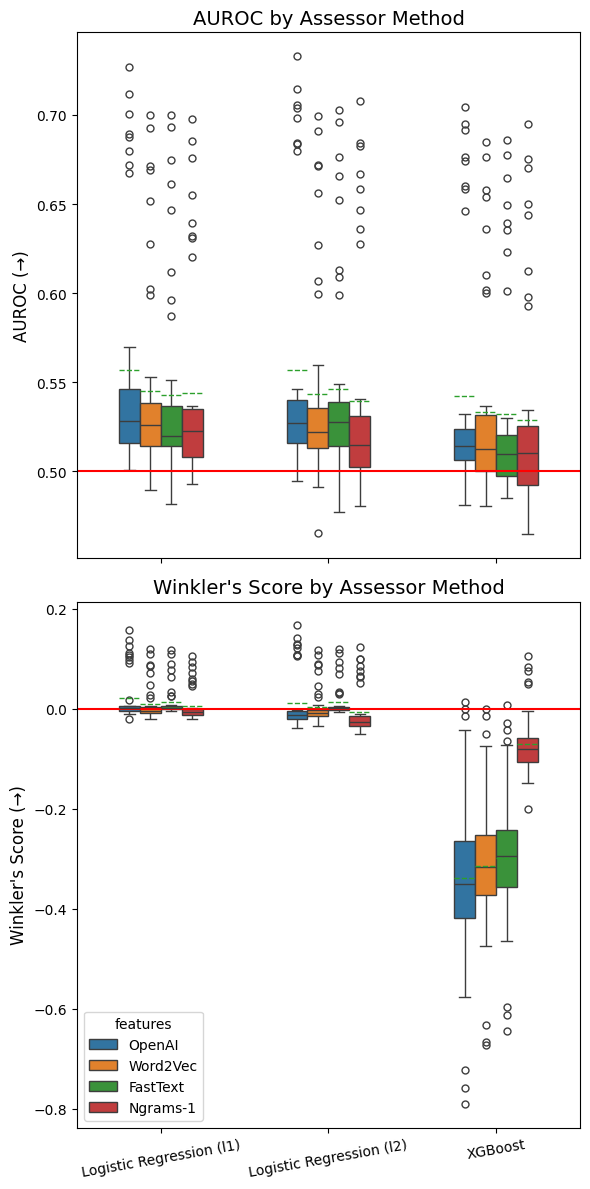

In [41]:
side_by_side = False

boxplot_params = {
    "showmeans": True,
    "meanline": True,
    "boxprops": dict(linewidth=1),
    "whiskerprops": dict(linewidth=1),
    "capprops": dict(linewidth=1),
    "flierprops": dict(marker='o', markersize=5),
    "medianprops": dict(linewidth=1),
    "meanprops": dict(linewidth=1),
    "width": 0.5,
    "hue_order": ['OpenAI', 'Word2Vec', 'FastText', 'Ngrams-1']
}

if not side_by_side:
    fig, axes = plt.subplots(2, 1, figsize=(6, 12), sharex=True)
else:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Left panel: AUROC
sns.boxplot(data=assessors_results_df, x='predictive_method', hue="features", y='AUROC_test', ax=axes[0], **boxplot_params)
axes[0].legend_.remove()  # Remove the legend from the first subplot since it gets in the way and we can see it in the second
axes[0].set_ylabel('AUROC (→)', fontsize=12)
axes[0].set_title('AUROC by Assessor Method', fontsize=14)
axes[0].tick_params(axis='x', rotation=10)
axes[0].set_xlabel("")
axes[0].axhline(y=0.5, color="r")

# Right panel: Winkler's Score
sns.boxplot(data=assessors_results_df, x='predictive_method', hue="features", y='WinklerScore_test', ax=axes[1], **boxplot_params)
axes[1].set_xlabel("")
axes[1].set_ylabel("Winkler's Score (→)", fontsize=12)
axes[1].set_title("Winkler's Score by Assessor Method", fontsize=14)
axes[1].tick_params(axis='x', rotation=10)
axes[1].axhline(y=0, color="r")

plt.tight_layout()
plt.savefig("experiments_AUROC_Winkler"+saved_figure_extension+".pdf", format="pdf")
plt.show()


# Finding the best LLM-Assessor pairs by PVR

The main metric we are interested in for assessors is the size of the PVR, as this is the size of the region in which the LLM can operate safely. Firstly we consider the top subject-assessor pairs for PVR thresholds 0.8, 0.9 and 0.95 (With a 0.99 threshold, it drops to near zero).

This is visualised in the below heatmap, showing the union of the top 10 for each threshold.

We can see that the LLM-assessor pairs get a fairly good score at a threshold of 0.8. This is to be expected when the LLMs are fairly good at the task, as the assessor can predict success most of the time. When the threshold is raised to 0.9 we see a very large drop in PVR, as now there is a greater requirement for assessors to make predictions that the LLM will fail.

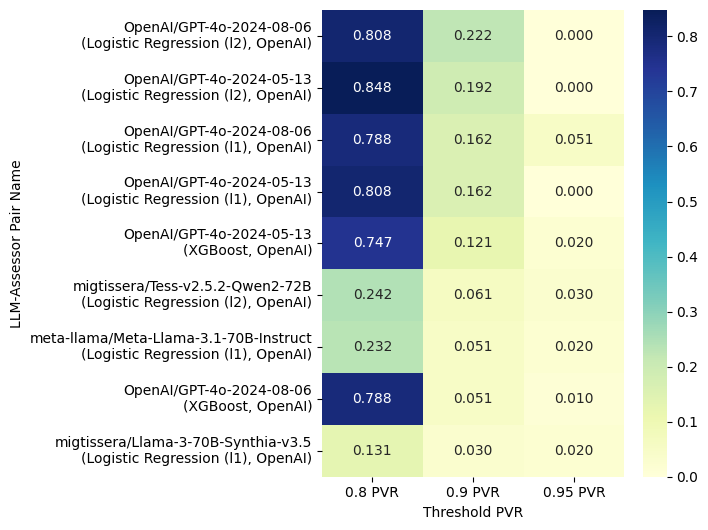

In [42]:
PLOT_TOP_NUM = 5
PVR_thresholds = [0.80, 0.90, 0.95]
# Identify the top pairs for each threshold
top_pairs_sets = []
for threshold in PVR_thresholds:
    PVR_col_name = f"{threshold} PVR"
    top_pairs_for_threshold = assessors_results_df.nlargest(PLOT_TOP_NUM, PVR_col_name)['pair_name'].unique()
    top_pairs_sets.append(set(top_pairs_for_threshold))
# Take the union of top pairs across all thresholds
all_top_pairs = set.union(*top_pairs_sets)
# Filter the dataframe to only these pairs
filtered_df = assessors_results_df[assessors_results_df['pair_name'].isin(all_top_pairs)]
# Keep only the relevant columns: pair_name and PVR columns
PVR_cols = [f"{t} PVR" for t in PVR_thresholds]
filtered_df = filtered_df[['pair_name'] + PVR_cols].drop_duplicates('pair_name')
# Set pair_name as the index
filtered_df = filtered_df.set_index('pair_name')
# Round values to 3 decimal places
filtered_df = filtered_df.round(3)
# Sort by the 0.9 PVR column
filtered_df_PVR = filtered_df.sort_values(by="0.9 PVR", ascending=False)
# Create a heatmap
scale_factor = 0.9
plt.figure(figsize=(8* scale_factor, 6 * scale_factor))
sns.heatmap(filtered_df_PVR, annot=True, cmap='YlGnBu', fmt='.3f')
plt.ylabel("LLM-Assessor Pair Name")
plt.xlabel("Threshold PVR")
plt.tight_layout()
# plt.rcParams.update({'font.size': 14})
plt.savefig("experiments_PPR"+saved_figure_extension+".pdf", format="pdf")
plt.show()

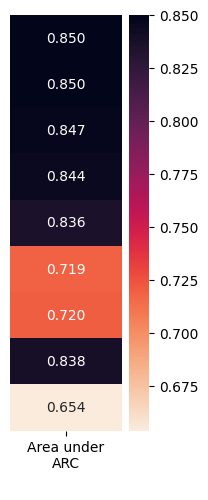

In [43]:
# Filter the dataframe to only the area_under_arc for pairs of interest
filtered_df = assessors_results_df[assessors_results_df['pair_name'].isin(all_top_pairs)]
filtered_df = filtered_df[["pair_name", "0.9 PVR", area_under_arc_col_name]].drop_duplicates('pair_name')
# # Set pair_name as the index
filtered_df = filtered_df.set_index('pair_name')
# # Sort by the 0.9 PVR column
filtered_df = filtered_df.sort_values(by="0.9 PVR", ascending=False)
# Remove the 0.9 PVR column
filtered_df = filtered_df[[area_under_arc_col_name]]
# # Round values to 3 decimal places
filtered_df_AUARC = filtered_df.round(3)

rocket_cmap = sns.color_palette("rocket", as_cmap=True)
rocket_cmap_reversed = rocket_cmap.reversed()

# # Create the heatmap
plt.figure(figsize=(2* scale_factor, 6 * scale_factor))
# # Capture the Axes object
ax = sns.heatmap(filtered_df_AUARC, annot=True, cmap=rocket_cmap_reversed, fmt='.3f', yticklabels=False)
ax.set_xlabel(" ")

# Remove the y-axis label
ax.set_ylabel('')
plt.savefig("area_under_arc"+saved_figure_extension+".pdf", format="pdf", bbox_inches='tight')

plt.show()

C:\Users\talkt\AppData\Local\Temp\ipykernel_28752\3732537195.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


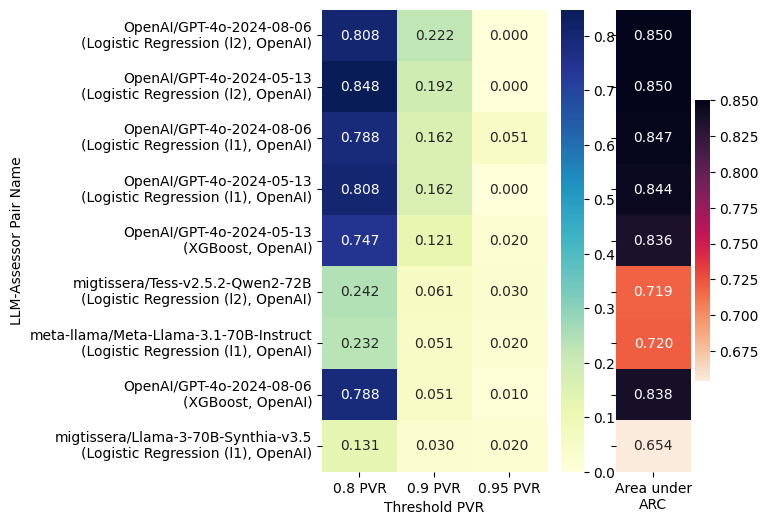

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# Define your scale factor (or set figure size as desired)
scale_factor = 1# 0.8

# Create a figure and a GridSpec to manage two subplots with different widths.
fig = plt.figure(figsize=(5 * scale_factor, 6 * scale_factor))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1], wspace=0.07)

# First heatmap: PVR values
ax1 = fig.add_subplot(gs[0])
sns.heatmap(
    filtered_df_PVR,        # your PVR dataframe
    annot=True,
    cmap='YlGnBu',
    fmt='.3f',
    ax=ax1,
    cbar=True               # show colorbar
)
ax1.set_ylabel("LLM-Assessor Pair Name")
ax1.set_xlabel("Threshold PVR")
ax1.tick_params(axis='y', labelrotation=0)
# Optionally rotate x tick labels if needed
# ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# Second heatmap: AUARC values
ax2 = fig.add_subplot(gs[1])
sns.heatmap(
    filtered_df_AUARC,       # your AUARC dataframe
    annot=True,
    cmap=rocket_cmap.reversed(),  # use the reversed rocket cmap
    fmt='.3f',
    ax=ax2,
    cbar=True               # independent colorbar for this heatmap
)
# ax2.set_xlabel("AUARC")
ax2.set_ylabel("")  # Remove y-axis label

# Manually align the y-axis ticks and limits with ax1
yticks = ax1.get_yticks()
ax2.set_yticks(yticks)       # set ticks to match
ax2.set_yticklabels([])      # hide the tick labels
ax2.set_ylim(ax1.get_ylim())  # ensure same y-axis limits

# Optionally rotate x tick labels for ax2
# ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.savefig("combined_heatmaps"+saved_figure_extension+".pdf", format="pdf", bbox_inches='tight')
plt.show()

# Plot Accuracy vs test AUROC/Winkler's Score

Text(0.5, 1.0, 'LLM Accuracy vs AUROC')

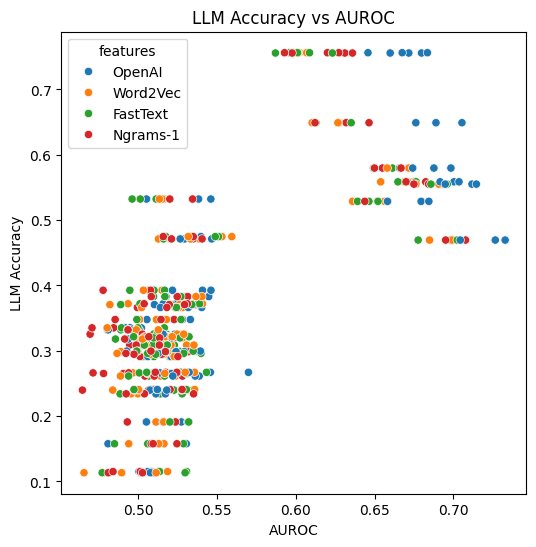

In [45]:
# assessors_results_df["llm_accuracy_test"] vs assessors_results_df["AUROC_test"]

plt.figure(figsize=(6, 6))
sns.scatterplot(data=assessors_results_df, x="AUROC_test", y="llm_accuracy_test", hue="features")
plt.xlabel("AUROC")
plt.ylabel("LLM Accuracy")
plt.title("LLM Accuracy vs AUROC")


Text(0.5, 1.0, "LLM Accuracy vs Winkler's Score")

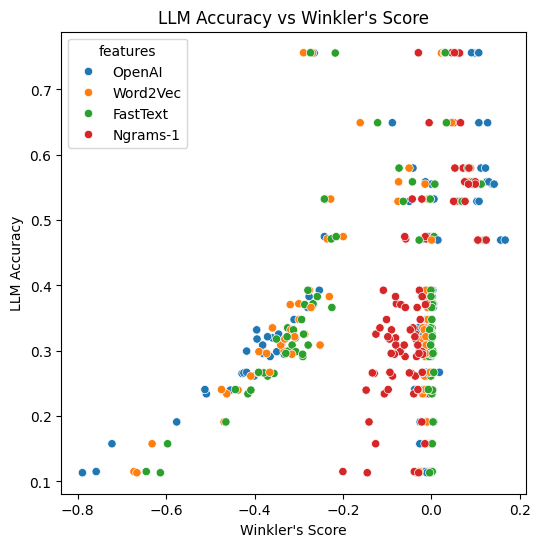

In [46]:
# assessors_results_df["llm_accuracy_test"] vs assessors_results_df["WinklerScore_test"]

plt.figure(figsize=(6, 6))
sns.scatterplot(data=assessors_results_df, x="WinklerScore_test", y="llm_accuracy_test", hue="features")
plt.xlabel("Winkler's Score")
plt.ylabel("LLM Accuracy")
plt.title("LLM Accuracy vs Winkler's Score")

# Investigating least predictable instances

In [47]:
assessors_results_df.columns

Index(['predictive_method', 'features', 'llm', 'BrierScore_val',
       'WinklerScore_val', 'Calibration_val', 'Refinement_val', 'AUROC_val',
       'BrierScore_test', 'WinklerScore_test', 'Calibration_test',
       'Refinement_test', 'AUROC_test', 'predictions_train', 'predictions_val',
       'predictions_test', 'arc_train', 'arc_test', 'arc_val',
       'llm_accuracy_train', 'llm_accuracy_val', 'llm_accuracy_test',
       'trained_classifier', 'feature_order', '0.8 PVR', '0.9 PVR', '0.95 PVR',
       'Area under\nARC', 'pair_name', 'predictive_method_features'],
      dtype='object')

In [48]:
assessors_results_df.head()

,predictive_method,features,llm,BrierScore_val,WinklerScore_val,Calibration_val,Refinement_val,AUROC_val,BrierScore_test,WinklerScore_test,...,llm_accuracy_val,llm_accuracy_test,trained_classifier,feature_order,0.8 PVR,0.9 PVR,0.95 PVR,Area under\nARC,pair_name,predictive_method_features
0,Logistic Regression (l1),OpenAI,Orenguteng__Llama-3.1-8B-Lexi-Uncensored-V2,0.234383,0.002322,0.000345,0.234015,0.530884,0.233786,-0.001031,...,0.376372,0.371981,"LogisticRegression(penalty='l1', solver='libli...",NaN,0.000000,0.000000,0.0,0.389531,Orenguteng/Llama-3.1-8B-Lexi-Uncensored-V2\n(L...,Logistic Regression (l1)_OpenAI
0,Logistic Regression (l1),OpenAI,Orenguteng__Llama-3.1-8B-Lexi-Uncensored,0.235695,0.000645,0.000184,0.235174,0.532220,0.234498,-0.003734,...,0.381203,0.370663,"LogisticRegression(penalty='l1', solver='libli...",NaN,0.000000,0.000000,0.0,0.376918,Orenguteng/Llama-3.1-8B-Lexi-Uncensored\n(Logi...,Logistic Regression (l1)_OpenAI
0,Logistic Regression (l1),OpenAI,MaziyarPanahi__calme-2.1-qwen2.5-72b,0.213951,0.135014,0.000502,0.214365,0.711273,0.218310,0.112177,...,0.563022,0.579710,"LogisticRegression(penalty='l1', solver='libli...",NaN,0.171717,0.080808,0.0,0.725563,MaziyarPanahi/calme-2.1-qwen2.5-72b\n(Logistic...,Logistic Regression (l1)_OpenAI
0,Logistic Regression (l1),OpenAI,awnr__Mistral-7B-v0.1-signtensors-1-over-4,0.176463,0.007442,0.000322,0.176063,0.539670,0.179425,-0.003213,...,0.229688,0.234080,"LogisticRegression(penalty='l1', solver='libli...",NaN,0.000000,0.000000,0.0,0.248229,awnr/Mistral-7B-v0.1-signtensors-1-over-4\n(Lo...,Logistic Regression (l1)_OpenAI
0,Logistic Regression (l1),OpenAI,wave-on-discord__qwent-7b,0.135698,-0.004602,0.000040,0.135627,0.522827,0.132589,-0.006760,...,0.162055,0.157664,"LogisticRegression(penalty='l1', solver='libli...",NaN,0.000000,0.000000,0.0,0.185408,wave-on-discord/qwent-7b\n(Logistic Regression...,Logistic Regression (l1)_OpenAI


We consider the best assessor-LLM pair in terms of 0.8 PVR

In [49]:
top_pair = assessors_results_df.nlargest(1, "0.8 PVR")['pair_name'].unique()
top_pair

array(['OpenAI/GPT-4o-2024-05-13\n(Logistic Regression (l2), OpenAI)'],
      dtype=object)

In [50]:
# extract the predictions on test set for that pair:
top_pair_predictions = assessors_results_df[assessors_results_df['pair_name'] == top_pair[0]]['predictions_test'].values[0]
len(top_pair_predictions)

2277

In [51]:
test_df_model_top_pair = test_df[["Success_OpenAI__GPT-4o-2024-05-13", "prompt"]]
# add the predictions as a new columns:
test_df_model_top_pair["prediction"] = top_pair_predictions

C:\Users\talkt\AppData\Local\Temp\ipykernel_28752\2183314297.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_model_top_pair["prediction"] = top_pair_predictions


In [52]:
# split instances where the model is correct and incorrect
correct_instances = test_df_model_top_pair[test_df_model_top_pair["Success_OpenAI__GPT-4o-2024-05-13"]]
incorrect_instances = test_df_model_top_pair[~test_df_model_top_pair["Success_OpenAI__GPT-4o-2024-05-13"]]

In [53]:
n = 20
# now sort in increasing order by prediction for the correct instances
correct_instances = correct_instances.sort_values(by="prediction")
correct_instances.head(n=n)
# print the first n prompts to a text file, with the associated prediction:
with open("correct_instances.txt", "w") as f:
    for i, row in correct_instances.head(n).iterrows():
        f.write(f"PROMPT {i+1}, Prediction: {row['prediction']}:\n{row['prompt']}\n\n")

# do the same without including the prediction line and cut after the "Answer:"
with open("correct_instances_no_pred.txt", "w") as f:
    for i, row in correct_instances.head(n).iterrows():
        prompt = row['prompt']
        f.write(f"{prompt[:prompt.find('Answer:')]}\n\n")

In [54]:
n = 20
# opposite for incorrect instances
incorrect_instances = incorrect_instances.sort_values(by="prediction", ascending=False)
incorrect_instances.head(n=n)
# print the first n prompts to a text file, with the associated prediction:
with open("incorrect_instances.txt", "w") as f:
    for i, row in incorrect_instances.head(n).iterrows():
        f.write(f"PROMPT {i+1}, Prediction: {row['prediction']}:\n{row['prompt']}\n\n")

# do the same without including the prediction line and cut after the "Answer:"
with open("incorrect_instances_no_pred.txt", "w") as f:
    for i, row in incorrect_instances.head(n).iterrows():
        prompt = row['prompt']
        f.write(f"{prompt[:prompt.find('Answer:')]}\n\n")

# ARC curve comparison

To demonstrate how assessors can vary in usefulness, we select the highest accuracy LLM (OpenAI__GPT-4o-2024-08-06) and compare the ARC curves for the assessors with the highest, and lowest PVR at a threshold of 0.9.

In [55]:
def plot_arc_curves(pairs_to_plot: List[str], title = None) -> None:
    llm_auc = pd.DataFrame(columns=["Assessor Name", "Rejection Rate", "Accuracy"])

    for _, row in assessors_results_df[
            ["pair_name", "arc_test", "0.9 PVR"]
        ].iterrows():
        res = row["arc_test"]
        if row["pair_name"] not in pairs_to_plot:
            # Don't plot all the graphs
            continue

        llm_auc = pd.concat(
            [
                llm_auc,
                pd.DataFrame(
                    {
                        "Assessor Name": row["pair_name"],
                        "Rejection Rate": [i for i, _ in res],
                        "Accuracy": [j for _, j in res],
                    }
                ),
            ],
            ignore_index=True,
        )

    # plot using seaborn
    # plt.figure(figsize=(10, 10))
    g = sns.relplot(
        data=llm_auc, kind="line", x="Rejection Rate", y="Accuracy", hue="Assessor Name", facet_kws={'legend_out': False}
    )
    if title is not None:
        g.figure.suptitle(title, y=1.02)
    g.set(ylim=(0.5, 1))
    plt.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, .25),
        ncol=1
    )
    plt.tight_layout()
    plt.savefig("experiments_ARC_crossing_pair.pdf", format="pdf")
    plt.show()

In [56]:
# plot the ARC curves for all assessors, ie all predictive method and all features. Use different line colors across features and different line styles across predictive methods
def plot_all_arc_curves(llm):
    llm_auc = pd.DataFrame(columns=["Assessor Name", "Rejection Rate", "Accuracy", "Features", "Predictive Method"])
    assessors_results_df_llm = assessors_results_df[assessors_results_df["llm"] == llm]
    
    for _, row in assessors_results_df_llm[
            ["pair_name", "arc_test", "features", "predictive_method"]
        ].iterrows():
        res = row["arc_test"]
        llm_auc = pd.concat(
            [
                llm_auc,
                pd.DataFrame(
                    {
                        "Assessor Name": row["pair_name"],
                        "Rejection Rate": [i for i, _ in res],
                        "Accuracy": [j for _, j in res],
                        "Features": row["features"],
                        "Predictive Method": row["predictive_method"]
                    }
                ),
            ],
            ignore_index=True,
        )

    plt.figure(figsize=(10, 10))
    sns.relplot(
        data=llm_auc, kind="line", x="Rejection Rate", y="Accuracy", hue="Features", style="Predictive Method", facet_kws={'legend_out': False}
    )
    plt.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, .3),
        ncol=2
    )
    plt.ylim(0.65, 1)
    plt.savefig("experiments_ARC_top_scorer.pdf", format="pdf")
    plt.show()

Total instances in the dataset: 11383
Top accuracy LLM: OpenAI__GPT-4o-2024-08-06


<Figure size 1000x1000 with 0 Axes>

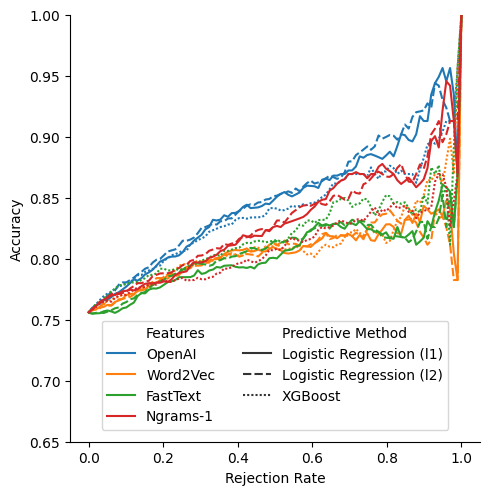

In [57]:
# Plot all ARC curves for the top accuracy LLM
all_results = pd.concat([train_df, validation_df, test_df], ignore_index=True)
print(f"Total instances in the dataset: {len(all_results)}")
num_samples = all_results.shape[0]
llm_columns = [col for col in all_results.columns if col.startswith('Success_')]

accuracy_per_llm = pd.DataFrame({
    # Remove "Success_model_outputs_" from the column name
    "llm": [col_name[8:] for col_name in llm_columns],
    "Accuracy": [all_results[col].sum()/num_samples for col in llm_columns]  # This works if values are boolean (True counts as 1)
})
top_accuracy_llm = accuracy_per_llm.loc[accuracy_per_llm["Accuracy"].idxmax(), "llm"]
print(f"Top accuracy LLM: {top_accuracy_llm}")

plot_all_arc_curves(top_accuracy_llm)

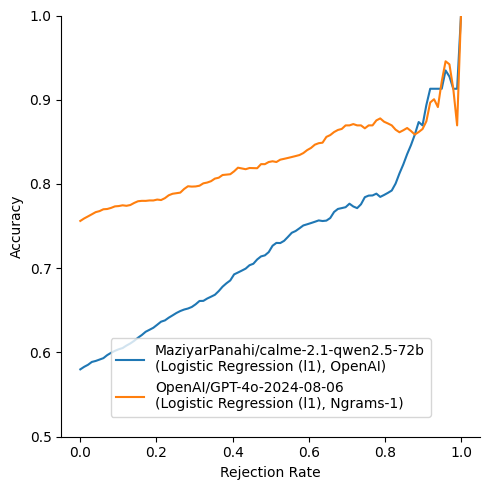

In [58]:
plot_arc_curves([
    "OpenAI/GPT-4o-2024-08-06\n(Logistic Regression (l1), Ngrams-1)", 
    "MaziyarPanahi/calme-2.1-qwen2.5-72b\n(Logistic Regression (l1), OpenAI)"
])

# Table/graph with LLM accuracy

                                                 llm  llm_accuracy_test  \
0                          OpenAI__GPT-4o-2024-05-13           0.756258   
0                          OpenAI__GPT-4o-2024-08-06           0.755819   
0                                OpenAI__GPT-4o-mini           0.649100   
0               MaziyarPanahi__calme-2.1-qwen2.5-72b           0.579710   
0                  migtissera__Tess-v2.5.2-Qwen2-72B           0.558630   
0            meta-llama__Meta-Llama-3.1-70B-Instruct           0.555116   
0                upstage__solar-pro-preview-instruct           0.532279   
0                       ssmits__Qwen2.5-95B-Instruct           0.528766   
0                        AbacusResearch__Jallabi-34B           0.474747   
0               NousResearch__Hermes-3-Llama-3.1-70B           0.471234   
0               migtissera__Llama-3-70B-Synthia-v3.5           0.469477   
0                                Aryanne__SuperHeart           0.392622   
0        migtissera__Tess

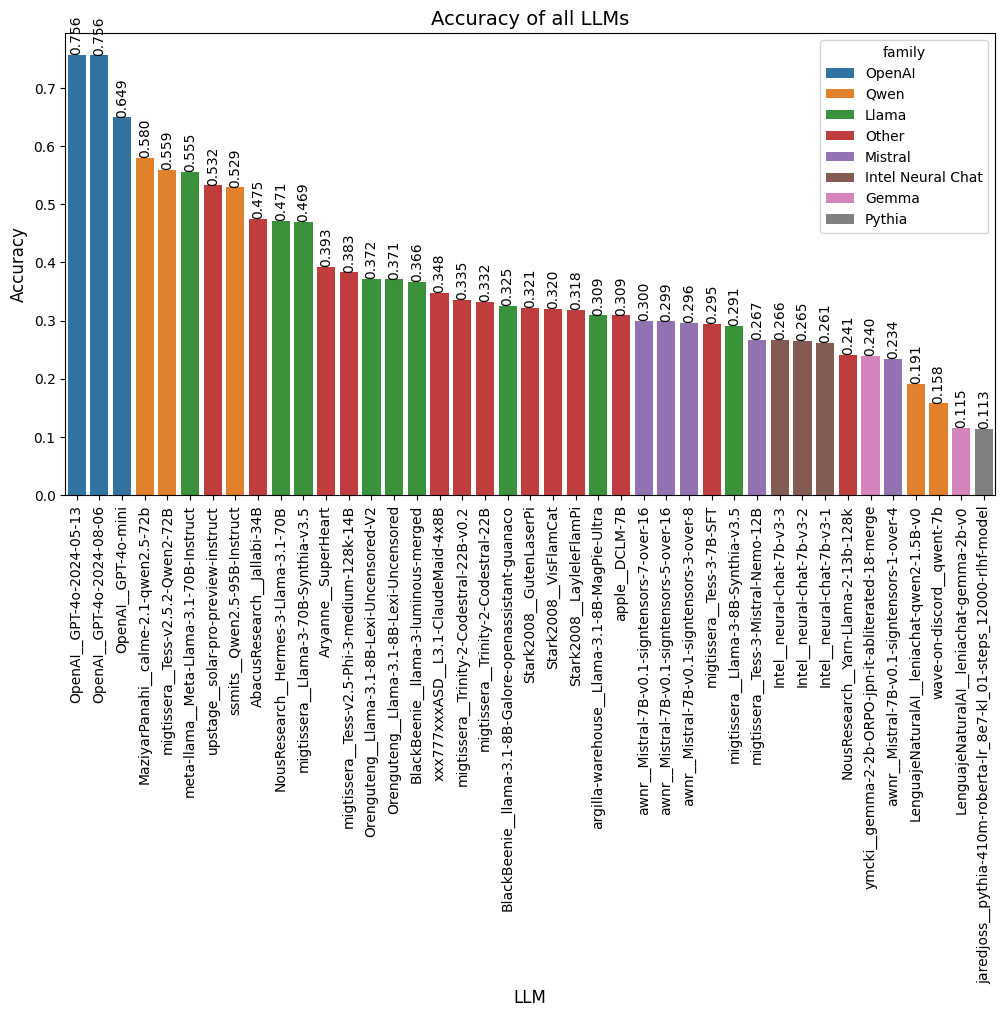

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example family mapping logic:
def get_family(llm_name):
    llm_name_lower = llm_name.lower()
    if "openai__gpt-" in llm_name_lower:
        return "OpenAI"
    elif "llama-3" in llm_name_lower or "meta-llama" in llm_name_lower or "nousresearch__hermes" in llm_name_lower:
        return "Llama"
    elif "mistral" in llm_name_lower:
        return "Mistral"
    elif "qwen" in llm_name_lower:
        return "Qwen"
    elif "gemma" in llm_name_lower:
        return "Gemma"
    elif "pythia" in llm_name_lower:
        return "Pythia"
    elif "intel__neural-chat" in llm_name_lower:
        return "Intel Neural Chat"
    # Add more conditions as needed to categorize your models
    else:
        return "Other"

# Create a family column based on the llm name
assessors_results_df['family'] = assessors_results_df['llm'].apply(get_family)

# Create a table with the accuracy of all LLMs
llm_accuracy_table = assessors_results_df[["llm", "llm_accuracy_test", "family"]]\
    .drop_duplicates()\
    .sort_values(by="llm_accuracy_test", ascending=False)

print(llm_accuracy_table)

# Plot a graph with the accuracy of all LLMs, using family for hue
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=llm_accuracy_table, x="llm", y="llm_accuracy_test", hue="family", dodge=False)

# add the value in the bars
# Iterate over each container (one per hue category)
for container in ax.containers:
    # ax.bar_label(container, fmt='%.3f', label_type='edge')  # Choose a suitable label_type
    # make them vertical
    ax.bar_label(container, label_type='edge', rotation=90, fmt='%.3f')

plt.xlabel('LLM', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy of all LLMs', fontsize=14)
plt.xticks(rotation=90)
#plt.legend(title='Family', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.tight_layout()
plt.savefig("llm_accuracy_"+test_dataset_name+".pdf", format="pdf")
plt.show()
